In [150]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn.cluster import DBSCAN

In [151]:
#"review_scores_rating", 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
#               'review_scores_location','review_scores_value'

In [237]:
cols_to_use = ["id", "source", "name", "description", "neighborhood_overview", "host_id", "host_name", "host_since", "host_location",
               "host_about", "host_response_rate", "host_acceptance_rate", "host_is_superhost", "host_verifications", "host_has_profile_pic", 
               "host_identity_verified", "neighbourhood_group_cleansed", "property_type", "room_type", "accommodates", "bathrooms", "bathrooms_text", 
               "bedrooms", "beds", "amenities", "price", "minimum_nights", "maximum_nights", "availability_365", "number_of_reviews",
               "instant_bookable", "calculated_host_listings_count"]

# Sort only according to the columns we want
df= pd.read_csv("./listings.csv", sep = ',', usecols = cols_to_use)

In [238]:
# Function to convert text description of listing to length (characters)
def text_to_len(df: pd.DataFrame, text_columns: list):
    for col in text_columns:
        df.loc[:,col] = df[col].apply(lambda x: len(str(x).split()) if isinstance(x, str) else 0)
    return df

# Relevant for ["name", "description", "neighborhood_overview", "host_about, "host_verifications", "amnenities"]

In [239]:
# Function to convert host_since dates to datetime to instead have a column representing how many days they have been host

def days_as_host(df: pd.DataFrame, date_col: str, reference_date: str):
    reference_date = pd.Timestamp(reference_date)
    df[date_col] = pd.to_datetime(df[date_col]) # Convert to datetime
    
    # Rename "host_since" to "days_as_host"
    df.rename(columns={date_col: 'days_as_host'}, inplace = True)
    
    # Calculate the number of days from reference date
    df['days_as_host'] = (reference_date - df['days_as_host']).dt.days

    return df
# Reference day: 05/09/2024 (since this is when it was last scraped)
# Relevant column: "host_since"

In [240]:
# Function to convert the attributes with "t" and "f" to "True" and "False"

def convert_to_boolean(df: pd.DataFrame, boolean_cols: list):
    for col in boolean_cols:
        df[col] = df[col].replace({'f':False, 't': True})        
    # Removing any listing with NaN values 
    df = df.dropna(subset=boolean_cols)
    return df

In [241]:
# Function to convert the location of the host, to "True/False" if they are in or outside of New York

def is_host_in_NY(df: pd.DataFrame, host_location: str):
    
    # Convert to true or false
    df.loc[:, host_location] = df[host_location].apply(lambda x: True if 'New York' in str(x) or 'NY' in str(x) else False)
    
    # Rename column
    df.rename(columns={host_location: 'host_in_NY'}, inplace=True)
    return df

In [242]:
# Function to convert lists to number of amenities of listing and verifications from host
def num_elements_in_list(df: pd.DataFrame, list_cols: list):
    for col in list_cols:
        df.loc[:, col] = df[col].apply(lambda x: len(eval(x)) if isinstance(x, str) else 0)
    return df

In [243]:
def number_and_type_bathroom(df: pd.DataFrame, bathroom_text: str):
    # Drop NaN values
    df = df.dropna(subset=[bathroom_text])
    
    # Initialize columns for private and shared bathrooms
    df['private_bathroom'] = 0
    df['shared_bathroom'] = 0
    
    # Function to extract number of bathrooms and type
    def extract_bathroom_info(text):
        text = text.lower()
        if 'shared half-bath' in text:
            return (0, 0.5)
        elif 'private half-bath' in text or 'half-bath' in text:
            return (0.5, 0)
        elif 'shared' in text:
            num_baths = float(text.split()[0])
            return (0, num_baths)
        elif 'private' in text:
            num_baths = float(text.split()[0])
            return (num_baths, 0)
        else:
            num_baths = float(text.split()[0])
            return (num_baths, 0)
    
    # Apply the function to each row
    df[['private_bathroom', 'shared_bathroom']] = df[bathroom_text].apply(lambda x: pd.Series(extract_bathroom_info(x)))
    
    return df

In [244]:
# Using the functions to clean the data
text_cols = ["name", "description", "neighborhood_overview", "host_about"]
boolean_cols = ["host_is_superhost", "host_has_profile_pic", "host_identity_verified", "instant_bookable"]
date_col = "host_since"
reference_date = "2024-09-05"
host_loc = "host_location"
list_cols = ["host_verifications", "amenities"]

df = df[df['source'] != 'previous scrape'] # !! Removing unavailable listings !!
df = text_to_len(df, text_cols)
df = days_as_host(df, date_col, reference_date)
df = convert_to_boolean(df, boolean_cols)
df = is_host_in_NY(df, host_loc)
df = num_elements_in_list(df, list_cols)
df = df.dropna(subset=['bedrooms']) # Drop rows where 'bedrooms' is NaN as we have no other information about number of beds
df = df.dropna(subset=['beds']) # Drop rows where 'bedrooms' is NaN as we have no other information about number of beds
df = df.dropna(subset=['price']) # Drop rows where price is NaN
df['price'] = df['price'].str.replace('$', '').str.replace(',', '').astype(float) # Convert str dollar price to numerical price


/var/folders/4m/s8hcw8_d02zgx8npr9k9fh4m0000gn/T/ipykernel_14325/2492182528.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace({'f':False, 't': True})


In [245]:
# LABEL or ONE-HOT ENOCDING
df = number_and_type_bathroom(df, 'bathrooms_text') # Now we have "private_bathroom" and "shared_bathroom"
df = pd.get_dummies(df, columns=['room_type'], prefix='room_type') # Now we have 'room_type_Entire home/apt', 'room_type_Hotel room',
                                                                    # 'room_type_Private room', 'room_type_Shared room' 

/var/folders/4m/s8hcw8_d02zgx8npr9k9fh4m0000gn/T/ipykernel_14325/549249987.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['private_bathroom'] = 0
/var/folders/4m/s8hcw8_d02zgx8npr9k9fh4m0000gn/T/ipykernel_14325/549249987.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['shared_bathroom'] = 0
/var/folders/4m/s8hcw8_d02zgx8npr9k9fh4m0000gn/T/ipykernel_14325/549249987.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [246]:
df = df.dropna()

In [247]:
def get_rates_categories(col):
    int_representation = int(col[:-1])
    if int_representation < 25:
        return 1
    elif int_representation >= 25 and int_representation < 50:
        return 2
    elif int_representation >= 50 and int_representation < 75:
        return 3
    else:
        return 4

In [248]:
df["host_response_rate_category"] = df["host_response_rate"].apply(lambda x: get_rates_categories(x))
df["host_acceptance_rate_category"] = df["host_acceptance_rate"].apply(lambda x: get_rates_categories(x))

In [249]:
columns_considered = ["name", "description", "neighborhood_overview", "days_as_host", "host_in_NY",
                      "host_about", "host_response_rate_category", "host_acceptance_rate_category", "host_is_superhost", 
                      "host_verifications", "host_has_profile_pic", "host_identity_verified", "neighbourhood_group_cleansed", 
                      "property_type", "accommodates", "bathrooms", "bathrooms_text", 
                      "bedrooms", "beds", "amenities", "price", "minimum_nights", "maximum_nights", "availability_365", "number_of_reviews",
                      "instant_bookable", "calculated_host_listings_count", "private_bathroom", "shared_bathroom", 
                      "room_type_Entire home/apt", "room_type_Hotel room", "room_type_Private room", "room_type_Shared room"]

In [250]:
df_final = df[columns_considered]

In [276]:
pd.set_option('display.max_columns', None)

In [251]:
numerical_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_final.select_dtypes(include=['object', 'category']).columns.tolist()
boolean_cols = df_final.select_dtypes(include=[bool]).columns.tolist()

In [252]:
df_final[boolean_cols] = df_final[boolean_cols].astype(int)

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical = encoder.fit_transform(df_final[categorical_cols])

/var/folders/4m/s8hcw8_d02zgx8npr9k9fh4m0000gn/T/ipykernel_14325/2538897322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[boolean_cols] = df_final[boolean_cols].astype(int)


In [253]:
scaler = StandardScaler()
# Concatenating numerical and boolean columns
numerical_and_boolean = df_final[numerical_cols + boolean_cols]
scaled_numerical_boolean = scaler.fit_transform(numerical_and_boolean)

In [254]:
encoded_categorical_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_cols))

preprocessed_df = pd.concat([pd.DataFrame(scaled_numerical_boolean, columns=numerical_cols + boolean_cols), encoded_categorical_df], axis=1)

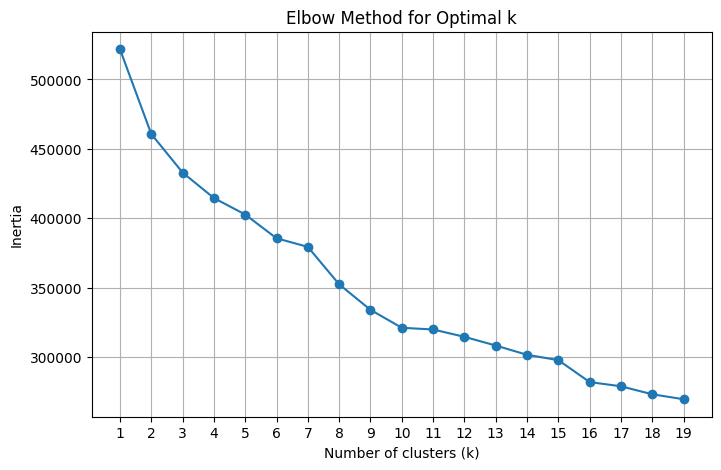

In [255]:
inertia = []
k_values = range(1, 20)  # You can adjust the range according to your needs

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=39)
    kmeans.fit(preprocessed_df)
    inertia.append(kmeans.inertia_)  # Store the inertia values

# Step 8: Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [256]:
optimal_k = 6

kmeans = KMeans(n_clusters=optimal_k, random_state=39)
kmeans.fit(preprocessed_df)

df_final['cluster'] = kmeans.labels_

/var/folders/4m/s8hcw8_d02zgx8npr9k9fh4m0000gn/T/ipykernel_14325/1547166533.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['cluster'] = kmeans.labels_


In [278]:
X = preprocessed_df  # Features
y = df_final['cluster']    # Targets based on clustering

# Step 10: Fit a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=190)
rf_model.fit(X, y)
tree_index = 1
estimator = rf_model.estimators_[tree_index]

# Step 3: Export the chosen tree to a dot file
dot_file = export_graphviz(estimator, 
                            out_file=None, 
                            feature_names=X.columns, 
                            class_names=[str(i) for i in range(optimal_k)],
                            filled=True, 
                            rounded=True, 
                            special_characters=True)

# Step 4: Visualize the tree using graphviz
graph = graphviz.Source(dot_file)
graph.view()  # Open the tree visualization

'Source.gv.pdf'

### DBSCAN Algorithm

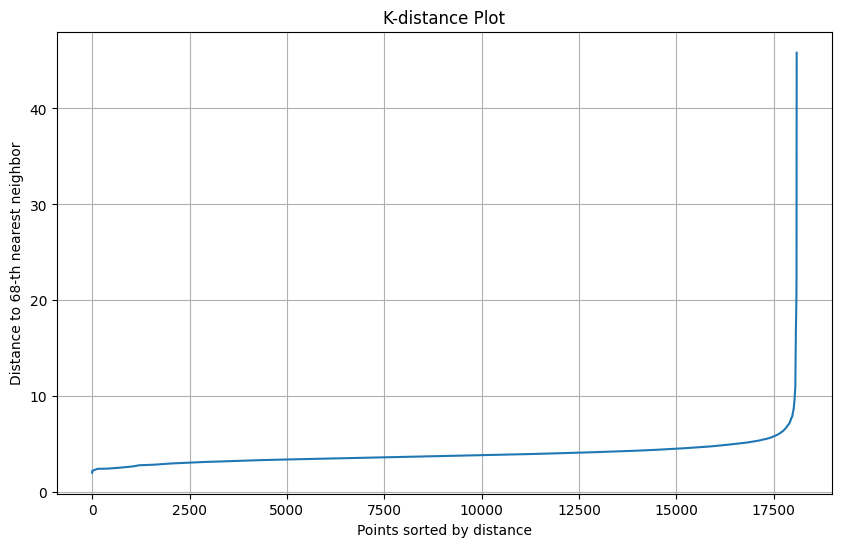

In [225]:
from sklearn.neighbors import NearestNeighbors

# Assume preprocessed_data is your data after preprocessing
min_samples = 68  # Set your min_samples for DBSCAN

# Fit Nearest Neighbors
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(preprocessed_df)
distances, indices = nbrs.kneighbors(preprocessed_df)

# Get the distances to the k-th nearest neighbor (min_samples)
k_distance = distances[:, min_samples - 1]  # Selecting the distance to the min_samples-neighbor

# Sort the K-distance
k_distance_sorted = np.sort(k_distance)

# Plot the K-distance graph
plt.figure(figsize=(10, 6))
plt.plot(k_distance_sorted)
plt.title('K-distance Plot')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {min_samples}-th nearest neighbor')
plt.grid(True)
plt.show()

In [226]:
eps = 7  # Maximum distance between two samples for them to be considered as in the same neighborhood
min_samples = 68  # Number of samples in a neighborhood for a point to be considered as a core point

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(preprocessed_df)

# Add cluster labels to the original data
df['cluster'] = clusters

In [227]:
# Count clusters and noise points
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # -1 indicates noise
n_noise = list(clusters).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

Estimated number of clusters: 4
Estimated number of noise points: 55


In [209]:
X = preprocessed_df  # Features
y = df['cluster']    # Targets based on clustering

# Step 10: Fit a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=60)
rf_model.fit(X, y)

# Step 11: Get Feature Importances
importances = rf_model.feature_importances_

# Step 12: Create a DataFrame for Visualization
feature_names = X.columns
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Step 13: Sort and Visualize Feature Importances
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

feature_importances_df.head()

,Feature,Importance
15,host_has_profile_pic,0.214310
19,room_type_Hotel room,0.114236
21,room_type_Shared room,0.077792
0,days_as_host,0.038975
664,property_type_Shared room in rental unit,0.036861


In [228]:
df_fin = df[df['cluster'] != -1]

### Merge listings and sentiments

In [262]:
df_sentiment = pd.read_csv("./NYtransREV.csv", header=[1], low_memory=False)
df_final_sentiment = df_sentiment[["listing_id", "com_neg_s", "com_neu_s", "com_pos_s", "comments"]]

In [263]:
df_final_sentiment["average_sentiment"] = df_final_sentiment["com_neg_s"] * -1 + df_final_sentiment["com_neu_s"] * 0 + df_final_sentiment["com_pos_s"] * 1

/var/folders/4m/s8hcw8_d02zgx8npr9k9fh4m0000gn/T/ipykernel_14325/1478042908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_sentiment["average_sentiment"] = df_final_sentiment["com_neg_s"] * -1 + df_final_sentiment["com_neu_s"] * 0 + df_final_sentiment["com_pos_s"] * 1


In [264]:
def categorize_sentiments(rw):
    if rw < -0.5:
        return "very bad"
    elif rw >= -0.5 and rw < -0.1:
        return "bad"
    elif rw >= -0.1 and rw < 0.1:
        return "neutral"
    elif rw >= 0.1 and rw <= 0.5:
        return "good"
    else:
        return "very good"

In [265]:
df_final_sentiment["sentiment_category"] = df_final_sentiment["average_sentiment"].apply(lambda x: categorize_sentiments(x))

/var/folders/4m/s8hcw8_d02zgx8npr9k9fh4m0000gn/T/ipykernel_14325/3061388814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_sentiment["sentiment_category"] = df_final_sentiment["average_sentiment"].apply(lambda x: categorize_sentiments(x))


In [268]:
df_final_sentiment[df_final_sentiment["sentiment_category"] == "bad"]

,listing_id,com_neg_s,com_neu_s,com_pos_s,comments,average_sentiment,sentiment_category
45,2595,0.454183,0.445519,0.100298,First of all I have to say that Jennifer is no...,-0.353886,bad
215,74680,0.442149,0.414147,0.143704,Nice place but keep your guard up Allot of gh...,-0.298446,bad
250,230877,0.549384,0.392404,0.058212,As long as you dont have a friend come stay fo...,-0.491173,bad
457,6848,0.575854,0.339352,0.084794,We chose this place based on photos location a...,-0.491060,bad
577,232612,0.395423,0.414303,0.190274,Dee was very kind to wait for us until late at...,-0.205150,bad
...,...,...,...,...,...,...,...
75106,1712660,0.352889,0.493140,0.153970,Alisons home was selected as a last minute sub...,-0.198919,bad
75173,1712660,0.430079,0.363700,0.206221,The room condition is older than shown on the ...,-0.223859,bad
75285,1716640,0.450092,0.464506,0.085402,Incredible She calculated the time from the ai...,-0.364690,bad
75308,1717058,0.491195,0.398847,0.109958,Prosbr Raynald is a very attentive host and ea...,-0.381237,bad


In [269]:
df_joined = pd.merge(df_final_sentiment, df_fin, left_on="listing_id", right_on="id", how="left")

In [270]:
df_joined = df_joined.dropna(subset=["id"])

In [272]:
df_joined.head()

,listing_id,com_neg_s,com_neu_s,com_pos_s,comments,average_sentiment,sentiment_category,id,source,name,...,calculated_host_listings_count,private_bathroom,shared_bathroom,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_response_rate_category,host_acceptance_rate_category,cluster
0,2595,0.005796,0.054793,0.939411,Great experience,0.933614,very good,2595.0,city scrape,3,...,3.0,1.0,0.0,True,False,False,False,3.0,1.0,0.0
1,2595,0.001715,0.006951,0.991333,Ive stayed with my friend at the Midtown Castl...,0.989618,very good,2595.0,city scrape,3,...,3.0,1.0,0.0,True,False,False,False,3.0,1.0,0.0
2,2595,0.002113,0.030226,0.967661,Weve been staying here for about 9 nights enjo...,0.965549,very good,2595.0,city scrape,3,...,3.0,1.0,0.0,True,False,False,False,3.0,1.0,0.0
3,2595,0.001277,0.007899,0.990824,We had a wonderful stay at Jennifers charming ...,0.989546,very good,2595.0,city scrape,3,...,3.0,1.0,0.0,True,False,False,False,3.0,1.0,0.0
4,2595,0.001034,0.012407,0.986559,Hi to everyonebrWould say our greatest complim...,0.985525,very good,2595.0,city scrape,3,...,3.0,1.0,0.0,True,False,False,False,3.0,1.0,0.0


### Frequent item analysis